In [1]:
import subprocess
import concurrent.futures
from itertools import product
from tqdm import tqdm
import pathlib
import xlsxwriter
import datetime
import time
from collections import OrderedDict
from skimage.filters import threshold_mean
from skimage.measure import regionprops, label
from skimage.morphology import closing, opening, disk
from skimage.segmentation import clear_border
from skimage.color import label2rgb
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
import copy
import cv2

In [2]:
%matplotlib inline

In [16]:
%matplotlib notebook

In [3]:
colors_li = [plt.cm.get_cmap('hsv', 30)(i) for i in range(30)]

In [23]:
im_li = [
    r"\\14.32.167.236\기술혁신팀$\파일전송(공용)\blur focusing.jpg",
    r"\\14.32.167.236\기술혁신팀$\파일전송(공용)\clear focusing.jpg",
    r"\\14.32.167.236\기술혁신팀$\파일전송(공용)\fam blur focusing.jpg",
    r"\\14.32.167.236\기술혁신팀$\파일전송(공용)\fam clear focusing.jpg",
]

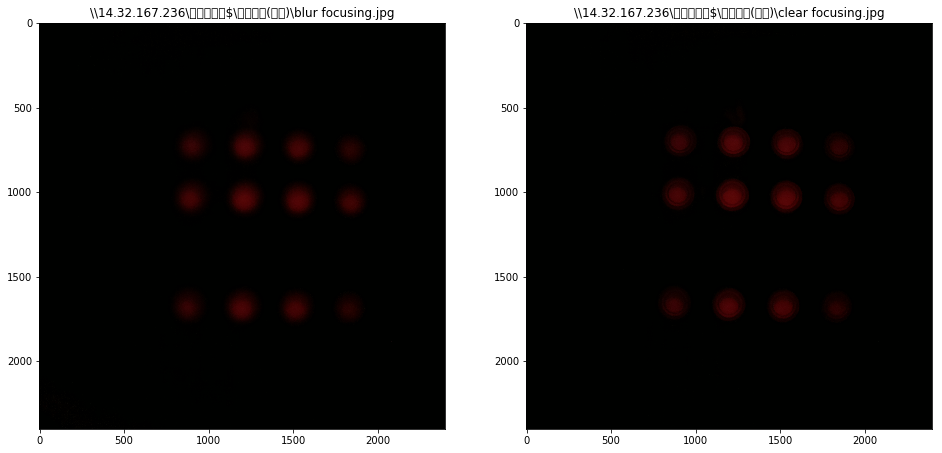

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
for i in range(2):
    im_path = im_li[i]
    im = np.array(Image.open(im_path))
    ax[i].imshow(im)
    ax[i].set_title(im_li[i])

<IPython.core.display.Javascript object>


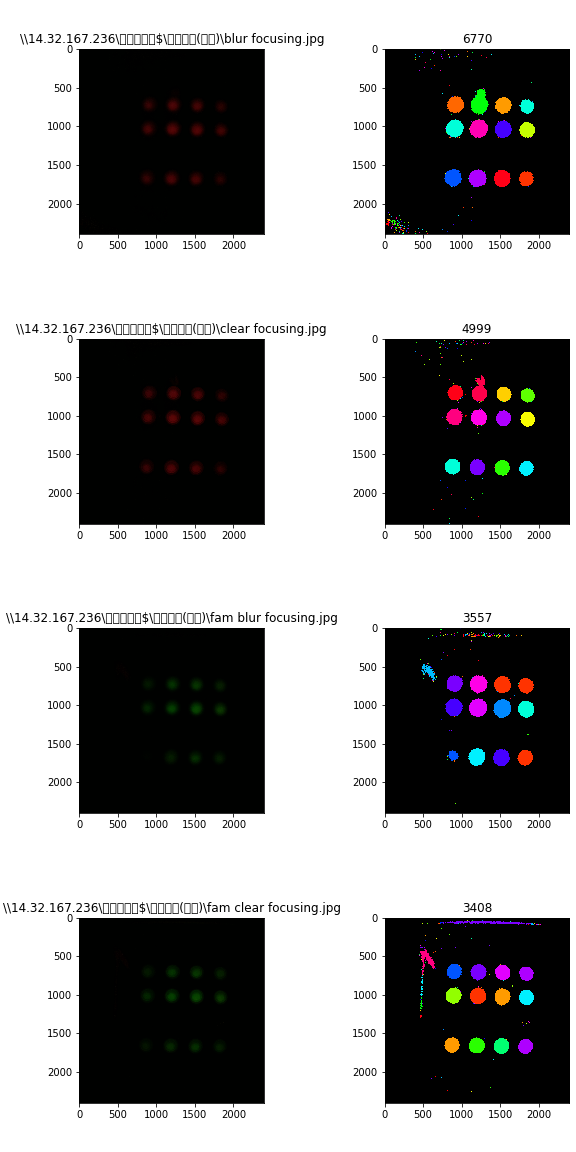

In [26]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16), constrained_layout=True)
for i in range(4):
    im_path = im_li[i]
    im = np.array(Image.open(im_path))
    ax[i, 0].imshow(im)
    ax[i, 0].set_title(im_li[i])
    im_gray = im.sum(axis=2)
    im_hue = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)[:, :, 2]
    cleared = clear_border(im_gray)
    thresh = threshold_mean(cleared)
    threshed_im = im_gray > thresh
    im_labeled = label(threshed_im)
    image_label_overlay = label2rgb(im_labeled, bg_label=0, colors=colors_li)
    ax[i, 1].imshow(image_label_overlay)
    ax[i, 1].set_title(im_labeled.max())

<IPython.core.display.Javascript object>


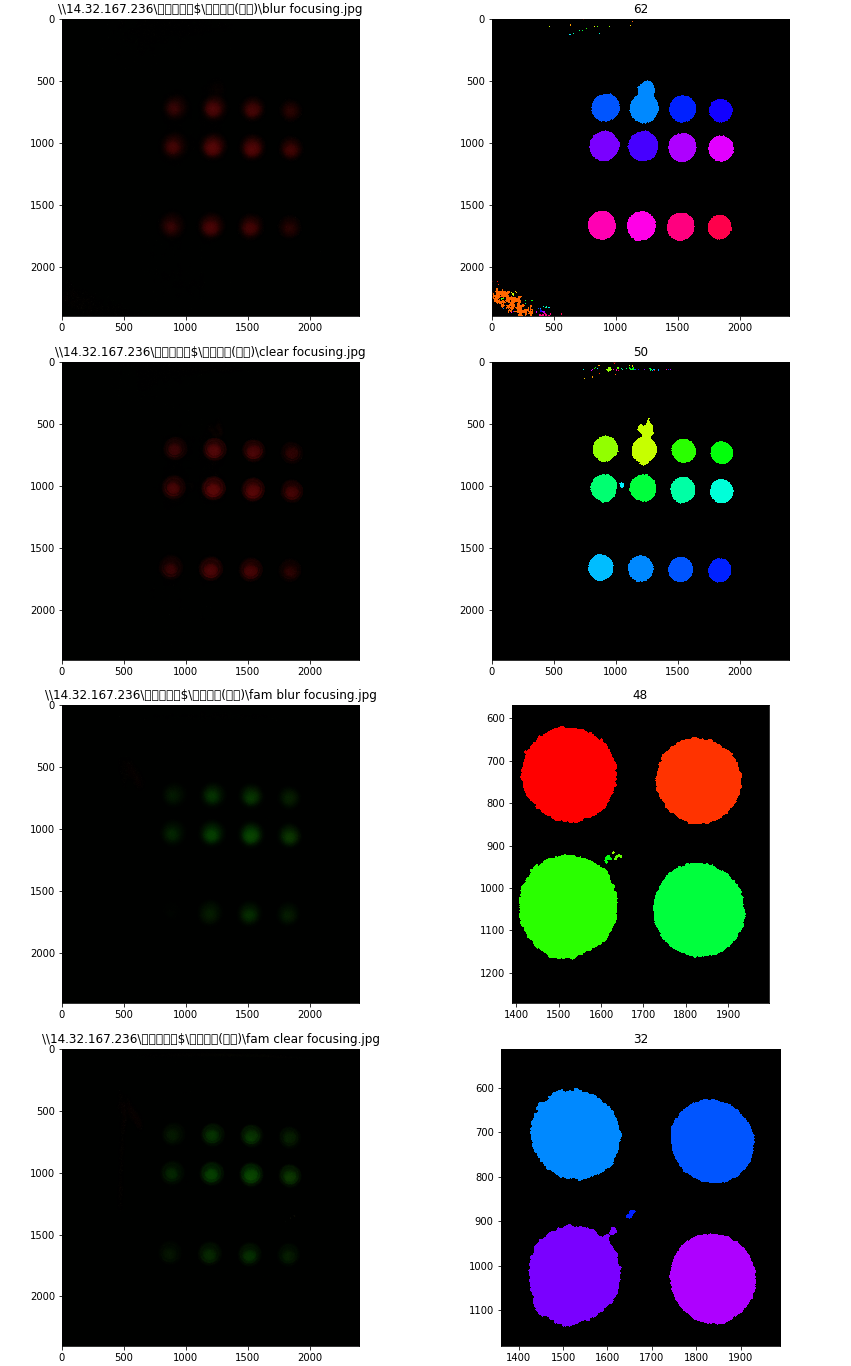

In [27]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16), constrained_layout=True)
for i in range(4):
    im_path = im_li[i]
    im = np.array(Image.open(im_path))
    ax[i, 0].imshow(im)
    ax[i, 0].set_title(im_li[i])
    im_gray = im.sum(axis=2)
    im_hue = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)[:, :, 2]
    cleared = clear_border(im_gray)
    thresh = threshold_mean(cleared)
    threshed_im = im_gray > thresh
    bw = closing(threshed_im, disk(3))
    bw2 = opening(bw, disk(3))
    im_labeled = label(bw2)
    image_label_overlay = label2rgb(im_labeled, bg_label=0, colors=colors_li)
    ax[i, 1].imshow(image_label_overlay)
    ax[i, 1].set_title(im_labeled.max())

In [8]:
def get_region_dic(im_labeled, im_gray):
    region_dic = {}
    for region in regionprops(im_labeled, intensity_image=im_gray):
        region_dic[region.area] = region
    return region_dic

In [57]:
def get_region_hue_dic(im_labeled, im_gray):
    region_dic = {}
    for region in regionprops(im_labeled, intensity_image=im_hue):
        region_dic[region.area] = region
    return region_dic

In [12]:
row_name = list('ABCD')
col_name = range(1, 5)
def get_well_name4grid(i, j):
    return row_name[j] + str(col_name[i])

In [58]:
region_dic = get_region_dic(im_labeled, im_gray)
region_hue_dic = get_region_hue_dic(im_labeled, im_gray)
areas_li = sorted(list(region_dic.keys()), reverse=True)[:16]
bbox_key_li = ['minr', 'minc', 'maxr', 'maxc']
bbox_dic = {}
for key in bbox_key_li:
    bbox_dic[key] = []
for key2 in areas_li:
    region = region_dic[key2]
    bbox_li = region.bbox
    for i, k in enumerate(bbox_key_li):
        bbox_dic[k] += [bbox_li[i]]
well_box = []
for key3 in bbox_key_li[:2]:
    well_box.append(sorted(bbox_dic[key3])[0]-50)
for key4 in bbox_key_li[2:]:
    well_box.append(sorted(bbox_dic[key4])[-1]+50)
x_li = np.linspace(well_box[1], well_box[3], 5, endpoint=True)
y_li = np.linspace(well_box[0], well_box[2], 5, endpoint=True)
pts_li = [(x, y) for x in x_li for y in y_li]
grid = {}
for ind in range(19):
    i, j = divmod(ind, 5)
    if j == 4:
        continue
    top_left_pt = pts_li[ind]
    bottom_right_pt = pts_li[ind+6]
    well = get_well_name4grid(i, j)
    grid[well] = [top_left_pt[1], top_left_pt[0],
                  bottom_right_pt[1], bottom_right_pt[0]]

In [59]:
region_hue_dic

{4: <skimage.measure._regionprops._RegionProperties at 0x1fe8aefd160>,
 3: <skimage.measure._regionprops._RegionProperties at 0x1fe8aedda58>,
 6: <skimage.measure._regionprops._RegionProperties at 0x1fe899e6a58>,
 1395: <skimage.measure._regionprops._RegionProperties at 0x1fe89b1cdd8>,
 8: <skimage.measure._regionprops._RegionProperties at 0x1fe8aeddc88>,
 1050: <skimage.measure._regionprops._RegionProperties at 0x1fe89b1cef0>,
 2: <skimage.measure._regionprops._RegionProperties at 0x1fe8aeddeb8>,
 1: <skimage.measure._regionprops._RegionProperties at 0x1fe8aefd128>,
 15179: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28f28>,
 17515: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28cc0>,
 17278: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28be0>,
 14819: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28978>,
 12: <skimage.measure._regionprops._RegionProperties at 0x1fe89b282b0>,
 19745: <skimage.measure._regionprops._RegionPropertie

In [60]:
region_dic

{4: <skimage.measure._regionprops._RegionProperties at 0x1fe8aeddb38>,
 3: <skimage.measure._regionprops._RegionProperties at 0x1fe8aedd518>,
 6: <skimage.measure._regionprops._RegionProperties at 0x1fe899e6d68>,
 1395: <skimage.measure._regionprops._RegionProperties at 0x1fe89b1cb70>,
 8: <skimage.measure._regionprops._RegionProperties at 0x1fe8aedd6a0>,
 1050: <skimage.measure._regionprops._RegionProperties at 0x1fe89b1c630>,
 2: <skimage.measure._regionprops._RegionProperties at 0x1fe8aedd8d0>,
 1: <skimage.measure._regionprops._RegionProperties at 0x1fe8aeddb00>,
 15179: <skimage.measure._regionprops._RegionProperties at 0x1fe89b2a160>,
 17515: <skimage.measure._regionprops._RegionProperties at 0x1fe89b2a1d0>,
 17278: <skimage.measure._regionprops._RegionProperties at 0x1fe89b2a0f0>,
 14819: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28b00>,
 12: <skimage.measure._regionprops._RegionProperties at 0x1fe89b28470>,
 19745: <skimage.measure._regionprops._RegionPropertie

In [37]:
def get_grid_loc(x, y):
    well_location_dict = copy.deepcopy(grid)
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            return well
    return None

def get_well_name(x, y, pts_center):
    well_location_dict = copy.deepcopy(grid)
    for well in well_location_dict.keys():
        y_min, x_min, y_max, x_max = well_location_dict[well]
        if y_min < y < y_max and x_min < x < x_max:
            radius = (x_max-x_min)/2 - 50
            pts_given = np.array([x, y])
            distance = np.linalg.norm(pts_given-pts_center)
            if distance < radius:
                return well, radius
    return None, None

def plot_grid(ax):
    for pts in grid.values():
        ax.scatter(pts[1], pts[0], c='g')
        ax.scatter(pts[3], pts[2], c='g')

<IPython.core.display.Javascript object>


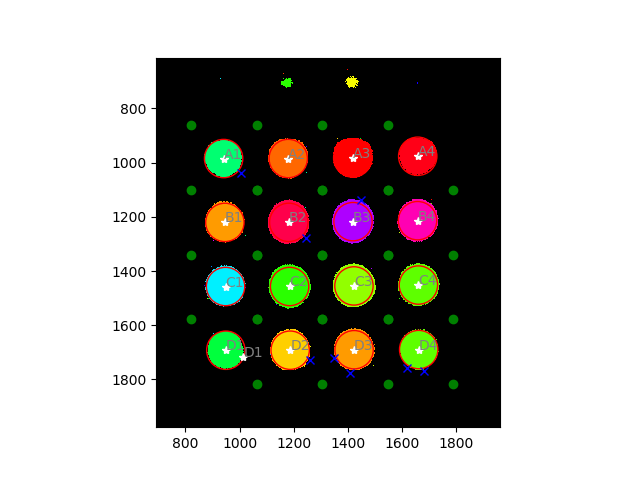

In [71]:
fig, ax = plt.subplots()
ax.imshow(image_label_overlay)
region_sum_dict = {}
region_sum_hue_dict = {}
for key in grid.keys():
    region_sum_dict[key] = 0
areas_li = sorted(list(region_dic.keys()), reverse=True)
center_at_cycle = {}
circle_li = []
for area in areas_li:
    region_obj = region_dic[area]
    region_hue_obj = region_hue_dic[area]
    y, x = region_obj.centroid
    grid_res = get_grid_loc(x, y)
    if grid_res is None:
        continue

    if grid_res not in center_at_cycle.keys():
        center = [x, y]
        center_at_cycle[grid_res] = center
        well, rad = get_well_name(x, y, center)
        circle_li.append(patches.Circle(
            center, radius=rad, color='r', fill=False,
            linewidth=1))
    else:
        center = center_at_cycle[grid_res]
    well, rad = get_well_name(x, y, center)

    if well is not None:
        region_sum_dict[well] += region_obj.intensity_image.sum()
#         region_sum_hue_dict[well] += region_hue_obj.intensity_image.sum()
        ax.plot(x, y, color='white', marker='*')
        ax.text(x, y, well, color='gray')
    else:
        ax.plot(x, y, color='b', marker='x')
plot_grid(ax)
for circle in circle_li:
    ax.add_artist(circle)
plt.show()

In [53]:
rfu_li = list(region_sum_dict.values())
rfu_avg = np.average(rfu_li)
rfu_std = np.std(rfu_li)
rfu_cv = rfu_std/rfu_avg
rfu_cv

0.35322747622007217